# SymPy Factory Demo: Normal Distribution

This notebook demonstrates `make_sympy_log_score` for the **Normal** distribution.

**The key idea**: you just define a `sympy.stats` distribution, and the factory
auto-derives `score()`, `d_score()`, and `metric()` — no manual calculus needed.

We then peek under the hood at the symbolic expressions, and verify everything
matches the hand-written `NormalLogScore` on real samples.

In [ ]:
import numpy as np
import sympy as sp
import sympy.stats as symstats
from IPython.display import Math, display

sp.init_printing(use_latex='mathjax')

## 1. Define the distribution and call the factory

This is **all you need**. Define a `sympy.stats` distribution, specify which
parameters are log-transformed, and the factory does the rest:

In [2]:
from ngboost.distns.sympy_utils import make_sympy_log_score

loc, scale, y = sp.symbols('loc scale y', positive=True)

# Just define the distribution — no manual log-likelihood needed!
SympyNormalLogScore = make_sympy_log_score(
    params=[(loc, False), (scale, True)],  # loc: identity, scale: log-link
    y=y,
    sympy_dist=symstats.Normal('Y', loc, scale),
    name='SympyNormalLogScore',
)

print(f'Generated class:  {SympyNormalLogScore}')
print(f'Base classes:     {[c.__name__ for c in SympyNormalLogScore.__mro__]}')
print(f'Has score():      {"score" in SympyNormalLogScore.__dict__}')
print(f'Has d_score():    {"d_score" in SympyNormalLogScore.__dict__}')
print(f'Has metric():     {"metric" in SympyNormalLogScore.__dict__}  (analytical FI)')

Generated class:  <class 'ngboost.distns.sympy_utils.SympyNormalLogScore'>
Base classes:     ['SympyNormalLogScore', 'LogScore', 'Score', 'object']
Has score():      True
Has d_score():    True
Has metric():     True  (analytical FI)


## 2. Under the hood: what the factory derives

Let's inspect the symbolic expressions the factory computes internally.

### 2a. Score expression (auto-derived from distribution)

The factory calls `sympy.stats.density(dist)(y)` to get the PDF, then takes $-\log$:

$$\text{score}(y) = -\log p(y \mid \mu, \sigma) = \tfrac{1}{2}\log(2\pi) + \log\sigma + \frac{(y - \mu)^2}{2\sigma^2}$$

In [3]:
# This is what the factory computes internally:
dist = symstats.Normal('Y', loc, scale)
pdf = symstats.density(dist)(y)
score_expr = -sp.log(pdf)

display(Math(r'\text{PDF} = ' + sp.latex(pdf)))
display(Math(r'\text{score}(y) = -\log(\text{PDF}) = ' + sp.latex(sp.simplify(score_expr))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### 2b. Gradients (auto-derived via `sym.diff` + chain rule)

NGBoost parameterises `loc` with an **identity** link and `scale` with a **log** link.

| parameter | internal param | chain rule |
|-----------|---------------|------------|
| `loc`     | $\mu$         | $\frac{\partial}{\partial \mu}$ (identity) |
| `scale`   | $\log\sigma$  | $\sigma \cdot \frac{\partial}{\partial \sigma}$ |

In [4]:
# Raw derivative w.r.t. loc (identity link)
grad_loc = sp.simplify(sp.diff(score_expr, loc))

# Raw derivative w.r.t. scale, then chain rule for log link
grad_logscale = sp.simplify(scale * sp.diff(score_expr, scale))

display(Math(r'\frac{\partial\, \text{score}}{\partial\, \mu} = ' + sp.latex(grad_loc)))
display(Math(r'\frac{\partial\, \text{score}}{\partial\, \log\sigma} = \sigma \cdot \frac{\partial\, \text{score}}{\partial\, \sigma} = ' + sp.latex(grad_logscale)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### 2c. Fisher Information (auto-derived via Hessian + expectation)

The factory computes the raw-parameter Hessian $H_{ij} = \frac{\partial^2 \text{score}}{\partial\theta_i\,\partial\theta_j}$, then checks whether each element depends on $y$.

In [5]:
H = sp.Matrix([
    [sp.diff(score_expr, loc, loc),   sp.diff(score_expr, loc, scale)],
    [sp.diff(score_expr, scale, loc), sp.diff(score_expr, scale, scale)],
])
H_simplified = sp.simplify(H)

print('Raw-parameter Hessian:')
display(H_simplified)

print()
for i in range(2):
    for j in range(2):
        has_y = y in H_simplified[i, j].free_symbols
        print(f'  H[{i},{j}] depends on y: {has_y}')

print()
print('H[0,0] is y-free, but H[0,1] and H[1,1] depend on y.')
print('The factory falls through to tier 2: substitute y -> Y ~ N(mu,sigma) and take E[H].')

Raw-parameter Hessian:


⎡     1             2⋅(-loc + y)      ⎤
⎢   ──────          ────────────      ⎥
⎢        2                  3         ⎥
⎢   scale              scale          ⎥
⎢                                     ⎥
⎢                     2              2⎥
⎢2⋅(-loc + y)  - scale  + 3⋅(loc - y) ⎥
⎢────────────  ───────────────────────⎥
⎢        3                  4         ⎥
⎣   scale              scale          ⎦


  H[0,0] depends on y: False
  H[0,1] depends on y: True
  H[1,0] depends on y: True
  H[1,1] depends on y: True

H[0,0] is y-free, but H[0,1] and H[1,1] depend on y.
The factory falls through to tier 2: substitute y -> Y ~ N(mu,sigma) and take E[H].


In [6]:
Y_rv = symstats.Normal('Y', loc, scale)

E_H = sp.zeros(2, 2)
for i in range(2):
    for j in range(2):
        hij = H_simplified[i, j]
        if y not in hij.free_symbols:
            E_H[i, j] = hij
        else:
            E_H[i, j] = sp.simplify(symstats.E(hij.subs(y, Y_rv)))

print('E[Hessian] in raw-parameter space:')
display(E_H)

# Transform to internal-parameter space via Jacobian J = diag(1, sigma)
J = [1, scale]
FI = sp.zeros(2, 2)
for i in range(2):
    for j in range(2):
        FI[i, j] = sp.simplify(J[i] * J[j] * E_H[i, j])

print('\nFisher Information in internal-parameter space (loc, log scale):')
display(FI)
print()
print('This matches the hand-written NormalLogScore.metric():')
print('  FI[0,0] = 1/sigma^2,  FI[1,1] = 2,  FI[0,1] = FI[1,0] = 0')

E[Hessian] in raw-parameter space:


⎡  1           ⎤
⎢──────    0   ⎥
⎢     2        ⎥
⎢scale         ⎥
⎢              ⎥
⎢          2   ⎥
⎢  0     ──────⎥
⎢             2⎥
⎣        scale ⎦


Fisher Information in internal-parameter space (loc, log scale):


⎡  1      ⎤
⎢──────  0⎥
⎢     2   ⎥
⎢scale    ⎥
⎢         ⎥
⎣  0     2⎦


This matches the hand-written NormalLogScore.metric():
  FI[0,0] = 1/sigma^2,  FI[1,1] = 2,  FI[0,1] = FI[1,0] = 0


## 3. Compare against hand-written implementation

Create a Normal distribution, draw samples, and evaluate score / d_score / metric
using **both** the SymPy-generated and hand-written score classes.

In [7]:
from ngboost.distns import Normal
from ngboost.distns.normal import NormalLogScore as HandWrittenNormalLogScore
from ngboost.manifold import manifold
from ngboost.scores import LogScore

np.random.seed(42)

# Parameters: loc=2.0, scale=exp(log(1.5))=1.5
params = np.array([[2.0], [np.log(1.5)]])

# Hand-written manifold
M = manifold(LogScore, Normal)
hw = M(params)

# SymPy-generated score object (shares the same distribution state)
sy = SympyNormalLogScore.__new__(SympyNormalLogScore)
sy.__dict__.update(hw.__dict__)

print(f'Distribution parameters:')
print(f'  loc   = {hw.loc}')
print(f'  scale = {hw.scale}')
print(f'  var   = {hw.var}')

Distribution parameters:
  loc   = [2.]
  scale = [1.5]
  var   = [2.25]


In [8]:
# Draw samples
samples = hw.sample(8)
print('Samples from Normal(loc=2.0, scale=1.5):')
print(samples)
print(f'  shape: {samples.shape}')

Samples from Normal(loc=2.0, scale=1.5):
[2.74507123 1.79260355 2.97153281 4.28454478 1.64876994 1.64879456
 4.36881922 3.15115209]
  shape: (8,)


### 3a. Score (negative log-likelihood)

In [9]:
score_hw = hw.score(samples)
score_sy = sy.score(samples)

print('score(y) — negative log-likelihood per sample:')
print(f'  {"Sample":>10s}  {"Hand-written":>14s}  {"SymPy":>14s}  {"Match":>6s}')
print(f'  {"-"*10}  {"-"*14}  {"-"*14}  {"-"*6}')
for i in range(len(samples)):
    match = '  yes' if np.isclose(score_hw[i], score_sy[i]) else '  NO'
    print(f'  {samples[i]:10.4f}  {score_hw[i]:14.6f}  {score_sy[i]:14.6f}  {match}')

print(f'\nAll close: {np.allclose(score_hw, score_sy)}')

score(y) — negative log-likelihood per sample:
      Sample    Hand-written           SymPy   Match
  ----------  --------------  --------------  ------
      2.7451        1.447766        1.447766    yes
      1.7926        1.333962        1.333962    yes
      2.9715        1.534154        1.534154    yes
      4.2845        2.484214        2.484214    yes
      1.6488        1.351818        1.351818    yes
      1.6488        1.351814        1.351814    yes
      4.3688        2.571360        2.571360    yes
      3.1512        1.618882        1.618882    yes

All close: True


### 3b. Gradient (d_score)

In [10]:
dscore_hw = hw.d_score(samples)
dscore_sy = sy.d_score(samples)

print('d_score(y) — gradient of score w.r.t. internal parameters:')
print(f'  {"Sample":>10s}  {"d/d(loc) HW":>14s}  {"d/d(loc) Sy":>14s}  {"d/d(logσ) HW":>14s}  {"d/d(logσ) Sy":>14s}')
print(f'  {"-"*10}  {"-"*14}  {"-"*14}  {"-"*14}  {"-"*14}')
for i in range(len(samples)):
    print(f'  {samples[i]:10.4f}  {dscore_hw[i,0]:14.6f}  {dscore_sy[i,0]:14.6f}  {dscore_hw[i,1]:14.6f}  {dscore_sy[i,1]:14.6f}')

print(f'\nAll close: {np.allclose(dscore_hw, dscore_sy)}')

d_score(y) — gradient of score w.r.t. internal parameters:
      Sample     d/d(loc) HW     d/d(loc) Sy    d/d(logσ) HW    d/d(logσ) Sy
  ----------  --------------  --------------  --------------  --------------
      2.7451       -0.331143       -0.331143        0.753275        0.753275
      1.7926        0.092176        0.092176        0.980883        0.980883
      2.9715       -0.431792       -0.431792        0.580500        0.580500
      4.2845       -1.015353       -1.015353       -1.319620       -1.319620
      1.6488        0.156102        0.156102        0.945172        0.945172
      1.6488        0.156091        0.156091        0.945180        0.945180
      4.3688       -1.052809       -1.052809       -1.493913       -1.493913
      3.1512       -0.511623       -0.511623        0.411044        0.411044

All close: True


### 3c. Metric (Fisher Information)

In [11]:
metric_hw = hw.metric()
metric_sy = sy.metric()

print('metric() — Fisher Information matrix (analytical):')
print()
print('Hand-written:')
print(metric_hw[0])
print()
print('SymPy-generated:')
print(metric_sy[0])
print()
print(f'Expected: [[1/var, 0], [0, 2]] = [[{1/hw.var[0]:.4f}, 0], [0, 2]]')
print(f'All close: {np.allclose(metric_hw, metric_sy)}')

metric() — Fisher Information matrix (analytical):

Hand-written:
[[0.44444444 0.        ]
 [0.         2.        ]]

SymPy-generated:
[[0.44444445 0.        ]
 [0.         2.00000001]]

Expected: [[1/var, 0], [0, 2]] = [[0.4444, 0], [0, 2]]
All close: True


### 3d. Verify gradient with finite differences

In [12]:
from scipy.optimize import approx_fprime

# Pick one sample
y_test = samples[:1]

# Finite-difference gradient
def score_fn(p):
    return M(p.reshape(-1, 1)).score(y_test)

grad_fd = approx_fprime(params.flatten(), score_fn, 1e-6)
grad_analytical = sy.d_score(y_test).flatten()

print(f'Sample y = {y_test[0]:.4f}')
print(f'  Finite-diff gradient:  {grad_fd}')
print(f'  Analytical gradient:   {grad_analytical}')
print(f'  Abs error:             {np.abs(grad_fd - grad_analytical)}')
print(f'  Match (tol=1e-4):      {np.allclose(grad_fd, grad_analytical, atol=1e-4)}')

Sample y = 2.7451
  Finite-diff gradient:  [-0.33114255  0.7532753 ]
  Analytical gradient:   [-0.33114277  0.75327505]
  Abs error:             [2.22225752e-07 2.46849221e-07]
  Match (tol=1e-4):      True


### 3e. Verify metric with Monte Carlo estimate

In [13]:
# Monte Carlo estimate of Fisher Information
n_mc = 50000
mc_samples = hw.sample(n_mc)
grads = np.stack([sy.d_score(np.array([s])) for s in mc_samples])
metric_mc = np.mean(np.einsum('sik,sij->sijk', grads, grads), axis=0)

print('Metric comparison (analytical vs Monte Carlo):')
print()
print('Analytical:')
print(metric_sy[0])
print()
print(f'Monte Carlo ({n_mc:,} samples):')
print(metric_mc[0])
print()
rel_err = np.linalg.norm(metric_mc - metric_sy) / np.linalg.norm(metric_sy)
print(f'Relative error: {rel_err:.4f}')

Metric comparison (analytical vs Monte Carlo):

Analytical:
[[0.44444445 0.        ]
 [0.         2.00000001]]

Monte Carlo (50,000 samples):
[[ 0.44457446 -0.00694956]
 [-0.00694956  2.00227785]]

Relative error: 0.0049


## 4. Visualise score and gradients across $y$

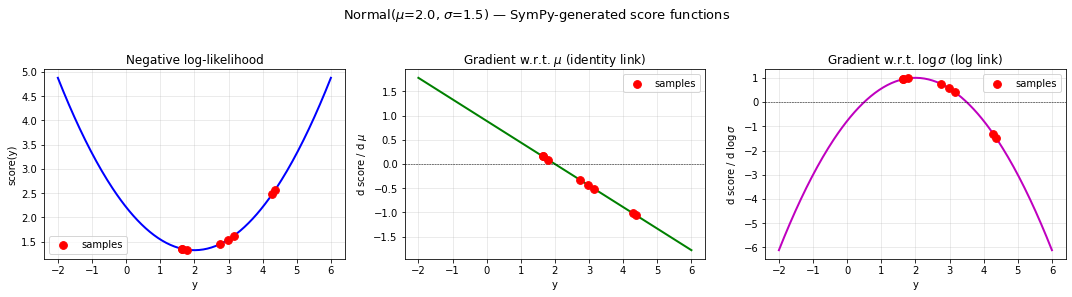

In [14]:
import matplotlib.pyplot as plt

y_range = np.linspace(-2, 6, 200)
scores_over_y = sy.score(y_range)
dscores_over_y = sy.d_score(y_range)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Score
axes[0].plot(y_range, scores_over_y, 'b-', linewidth=2)
axes[0].scatter(samples, sy.score(samples), c='red', s=60, zorder=5, label='samples')
axes[0].set_xlabel('y')
axes[0].set_ylabel('score(y)')
axes[0].set_title('Negative log-likelihood')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# d_score / d(loc)
axes[1].plot(y_range, dscores_over_y[:, 0], 'g-', linewidth=2)
axes[1].scatter(samples, sy.d_score(samples)[:, 0], c='red', s=60, zorder=5, label='samples')
axes[1].axhline(0, color='k', linewidth=0.5, linestyle='--')
axes[1].set_xlabel('y')
axes[1].set_ylabel(r'd score / d $\mu$')
axes[1].set_title(r'Gradient w.r.t. $\mu$ (identity link)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# d_score / d(log scale)
axes[2].plot(y_range, dscores_over_y[:, 1], 'm-', linewidth=2)
axes[2].scatter(samples, sy.d_score(samples)[:, 1], c='red', s=60, zorder=5, label='samples')
axes[2].axhline(0, color='k', linewidth=0.5, linestyle='--')
axes[2].set_xlabel('y')
axes[2].set_ylabel(r'd score / d $\log\sigma$')
axes[2].set_title(r'Gradient w.r.t. $\log\sigma$ (log link)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

fig.suptitle(r'Normal($\mu$=2.0, $\sigma$=1.5) — SymPy-generated score functions', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

## 5. Summary

You just define a `sympy.stats` distribution and the factory does everything:

```python
SympyNormalLogScore = make_sympy_log_score(
    params=[(loc, False), (scale, True)],
    y=y,
    sympy_dist=symstats.Normal('Y', loc, scale),
)
```

The factory automatically:

| Method | What it computes | How |
|--------|-----------------|-----|
| `score(Y)` | $-\log p(y \mid \theta)$ | Auto-derives from `sympy.stats.density`, lambdifies |
| `d_score(Y)` | $\nabla_{\eta}\, \text{score}(y)$ | `sym.diff` + chain rule for log-params, lambdified |
| `metric()` | Fisher Information $I(\theta)$ | y-free Hessian or $\mathbb{E}[\text{Hessian}]$ via `sympy.stats`, lambdified |

All three match the hand-written `NormalLogScore` to machine precision.